# Combining PCTA, WCDT and GSE221601 datasets for prostate cancer

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import rpy2.robjects as ro
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
from r_wrappers.deseq2 import vst_transform
from r_wrappers.sva import combat_seq
from r_wrappers.utils import pd_df_to_rpy2_df, rpy2_df_to_pd_df

### Global Variables

In [5]:
PCTA_WCDT_ROOT: Path = Path("/media/ssd/Perez/storage/PCTA_WCDT")

GSE221601_ROOT: Path = Path("/media/ssd/Perez/storage/GSE221601")
GSE221601_COUNTS_PATH: Path = GSE221601_ROOT / "data" / "star_unstranded_counts"

PCTA_WCDT_GSE221601_ROOT: Path = Path("/media/ssd/Perez/storage/PCTA_WCDT_GSE221601")
PCTA_WCDT_GSE221601_ROOT.mkdir(exist_ok=True, parents=True)
(PCTA_WCDT_GSE221601_ROOT / "data").mkdir(exist_ok=True, parents=True)

## 1. Load and merge annotation data from all datasets

### 1.1. PCTA - WCDT

In [6]:
annot_df_pcta_wcdt = pd.read_csv(
    PCTA_WCDT_ROOT / "data" / "samples_annotation.csv",
    index_col=0,
)
display(annot_df_pcta_wcdt.head())

,dataset,patient_id,sample_id,sample_type,ethnicity,diagnosis_age,biopsy_age,psa_level_________________________(at_diagonosis_for_crpc),gleason_score,gleason_score_of_initial_primary_tumor,...,is_tumor,affection,sex,race,file_id,file_name,data_category,data_type,project_id,sample_id.1
entry_1,GSE120795,SRR7961228,SRR7961228,norm,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entry_897,PRJEB21092,V4,1065RP-LN,met,NaN,NaN,51.0,43.00,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entry_819,PRJEB21092,V20,1135RP,prim,NaN,NaN,73.0,11.15,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entry_820,PRJEB21092,V21,703LP,prim,NaN,NaN,71.0,0.86,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entry_822,PRJEB21092,V22,482RT,prim,NaN,NaN,65.0,15.00,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
annot_df_pcta_wcdt["sample_type"].value_counts()

sample_type
prim         662
met          336
norm         174
met_neuro     19
Name: count, dtype: int64

In [8]:
annot_df_pcta_wcdt = annot_df_pcta_wcdt[
    annot_df_pcta_wcdt["sample_type"].isin(("norm", "prim", "met"))
]
annot_df_pcta_wcdt["sample_type"] = annot_df_pcta_wcdt["sample_type"].replace(
    "met", "mcrpc"
)
annot_df_pcta_wcdt["sample_type"].value_counts()

sample_type
prim     662
mcrpc    336
norm     174
Name: count, dtype: int64

### 1.2. GSE221601

In [9]:
annot_df_gse221601 = pd.read_csv(
    GSE221601_ROOT / "data" / "samples_annotation.csv", index_col=0
)
display(annot_df_gse221601.head())

,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,...,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,cluster_subtype
Run,,,,,,,,,,,,,,,,,,,,,
SRR22868605,RNA-Seq,200,3118990600,PRJNA915071,SAMN32372324,1397896683,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:38:00Z,1,GSM6890182,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868606,RNA-Seq,200,2437501200,PRJNA915071,SAMN32372325,1089843290,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:25:00Z,1,GSM6890181,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868607,RNA-Seq,200,4465919800,PRJNA915071,SAMN32372326,1924590452,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:34:00Z,1,GSM6890180,Prostate cancer,SRP414492,Prostate cancer,NaN
SRR22868608,RNA-Seq,200,6239105400,PRJNA915071,SAMN32372327,2739084770,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:38:00Z,1,GSM6890179,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868609,RNA-Seq,200,7531102000,PRJNA915071,SAMN32372328,3294991515,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:41:00Z,1,GSM6890178,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low


In [10]:
annot_df_gse221601["release_year"] = pd.to_datetime(
    annot_df_gse221601["ReleaseDate"]
).dt.year
annot_df_gse221601["disease_state"] = annot_df_gse221601["disease_state"].replace(
    {"Normal": "norm", "Tumor": "hspc"}
)

In [11]:
annot_df_gse221601.iloc[0, :]

Assay Type                                                      RNA-Seq
AvgSpotLen                                                          200
Bases                                                        3118990600
BioProject                                                  PRJNA915071
BioSample                                                  SAMN32372324
Bytes                                                        1397896683
Center Name           PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...
Consent                                                          public
DATASTORE filetype                                     fastq,run.zq,sra
DATASTORE provider                                           gs,ncbi,s3
DATASTORE region                   gs.us-east1,ncbi.public,s3.us-east-1
disease_state                                                      hspc
Experiment                                                  SRX18827362
Instrument                                          Illumina HiS

### 1.3. Combine all annotation data into a common format

In [12]:
annot_df = pd.DataFrame(
    columns=["sample_id", "patient_id", "sample_type", "dataset", "library_type"]
)

In [13]:
annot_df["sample_id"] = (
    annot_df_pcta_wcdt.index.tolist() + annot_df_gse221601.index.tolist()
)
annot_df["patient_id"] = (
    annot_df_pcta_wcdt["patient_id"].tolist() + annot_df_gse221601["BioSample"].tolist()
)
annot_df["sample_type"] = (
    annot_df_pcta_wcdt["sample_type"].tolist()
    + annot_df_gse221601["disease_state"].tolist()
)
annot_df["dataset"] = (
    annot_df_pcta_wcdt["dataset"].tolist() + ["GSE221601"] * annot_df_gse221601.shape[0]
)
annot_df["library_type"] = (
    annot_df_pcta_wcdt["library_type"].tolist()
    + ["total_rna"] * annot_df_gse221601.shape[0]
)

In [14]:
annot_df.sort_values(by="sample_type", ascending=False).to_csv(
    PCTA_WCDT_GSE221601_ROOT / "data" / "samples_annotation.csv", index=False
)

In [15]:
pd.read_csv(PCTA_WCDT_GSE221601_ROOT / "data" / "samples_annotation.csv", index_col=0)

,patient_id,sample_type,dataset,library_type
sample_id,,,,
entry_357,TCGA-G9-6342-01,prim,TCGA,poly_a
entry_498,TCGA-VP-A875-01,prim,TCGA,poly_a
entry_520,TCGA-J4-A83I-01,prim,TCGA,poly_a
entry_521,TCGA-EJ-A8FP-01,prim,TCGA,poly_a
entry_522,TCGA-J4-A83J-01,prim,TCGA,poly_a
...,...,...,...,...
SRR22868633,SAMN32372352,hspc,GSE221601,total_rna
SRR22868634,SAMN32372353,hspc,GSE221601,total_rna
SRR22868635,SAMN32372354,hspc,GSE221601,total_rna


## 2. Load and merge RNA-Seq expression data from all datasets

### 2.1. PCTA + WCDT

In [16]:
pcta_wcdt_raw_counts = pd.read_csv(
    PCTA_WCDT_ROOT / "data" / "raw_counts.csv", index_col=0
)

### 2.1. GSE221601

In [17]:
gse221601_counts = []
for sample_counts in GSE221601_COUNTS_PATH.glob("*.tsv"):
    star_count = (
        pd.read_csv(sample_counts, sep="\t", index_col=0, header=None, names=["count"])
        .squeeze("columns")
        .rename(sample_counts.stem)
    )
    gse221601_counts.append(star_count)

In [18]:
gse221601_raw_counts = pd.concat(gse221601_counts, axis=1)
gse221601_raw_counts.to_csv(PCTA_WCDT_GSE221601_ROOT / "data" / "raw_counts.csv")

In [19]:
counts_df = (
    pd.concat(
        [
            pcta_wcdt_raw_counts,
            gse221601_raw_counts,
        ],
        axis=1,
    )
    .dropna(axis=0)
    .astype(int)
)
counts_df = counts_df[counts_df.columns.intersection(annot_df["sample_id"])]
counts_df.to_csv(PCTA_WCDT_GSE221601_ROOT / "data" / "raw_counts.csv", index=True)

In [20]:
pd.read_csv(PCTA_WCDT_GSE221601_ROOT / "data" / "raw_counts.csv", index_col=0)

,entry_1,entry_2,entry_3,entry_4,entry_5,entry_6,entry_7,entry_8,entry_9,entry_10,...,SRR22868655,SRR22868656,SRR22868657,SRR22868658,SRR22868659,SRR22868660,SRR22868661,SRR22868662,SRR22868663,SRR22868664
ENSG00000223972,0,0,0,0,0,0,3,0,0,4,...,2,0,3,1,116,1,163,0,78,149
ENSG00000227232,0,0,3,0,0,0,100,126,570,501,...,126,214,234,185,402,762,663,450,783,430
ENSG00000278267,0,0,0,0,0,0,0,5,29,39,...,0,0,0,0,0,0,1,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ENSG00000284332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,15574,12190,5739,251648,552938,23346,10075,8282,88645,40438,...,180,104,115,505,115,125,172,99,273,351
ENSG00000210194,3,0,5,67,78,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000198727,60039,38387,28159,754732,1398135,102360,183753,149202,1666819,974743,...,317,308,229,1425,192,307,333,193,596,619
ENSG00000210195,2,0,1,17,60,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Perform batch correction

In [21]:
annot_df.set_index("sample_id", inplace=True)
annot_df["dataset_library_type"] = LabelEncoder().fit_transform(
    annot_df["dataset"] + "_" + annot_df["library_type"]
)

In [22]:
counts_by_type = {}
for sample_type in annot_df["sample_type"].unique():
    counts_by_type[sample_type] = counts_df[
        annot_df[annot_df["sample_type"] == sample_type].index
    ]
    counts_by_type[sample_type].to_csv(
        PCTA_WCDT_GSE221601_ROOT / "data" / f"{sample_type}_raw_counts.csv"
    )

### 3.1. Unprocessed (not yet batch-corrected) data

In [23]:
vst_by_type = {}
for sample_type, df in counts_by_type.items():
    vst_by_type[sample_type] = rpy2_df_to_pd_df(
        vst_transform(ro.r("as.matrix")(pd_df_to_rpy2_df(df.loc[df.mean(axis=1) > 10])))
    )
    vst_by_type[sample_type].to_csv(
        PCTA_WCDT_GSE221601_ROOT / "data" / f"{sample_type}_vst.csv"
    )

In [24]:
vst_df = rpy2_df_to_pd_df(
    vst_transform(
        ro.r("as.matrix")(pd_df_to_rpy2_df(counts_df.loc[counts_df.mean(axis=1) > 10]))
    )
)

In [25]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vst_df.T)

pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"], index=vst_df.columns)
pca_df["sample_type"] = annot_df.loc[vst_df.columns, "sample_type"].values
pca_df["dataset"] = annot_df.loc[vst_df.columns, "dataset"].values
pca_df["library_type"] = annot_df.loc[vst_df.columns, "library_type"].values
explained_variance = pca.explained_variance_ratio_

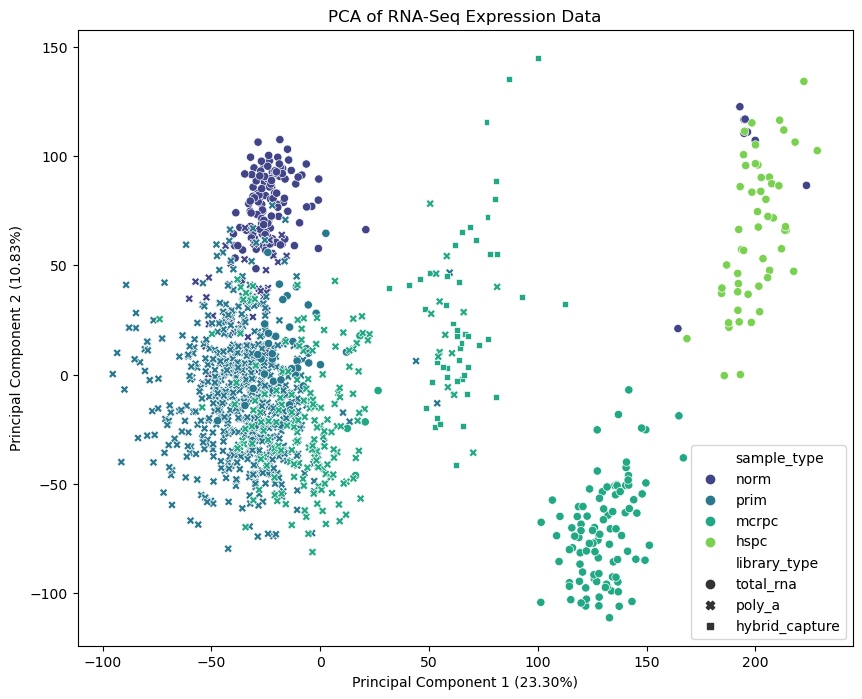

In [26]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="sample_type",
    style="library_type",
    data=pca_df,
    palette="viridis",
)
plt.title("PCA of RNA-Seq Expression Data")
plt.xlabel(f"Principal Component 1 ({explained_variance[0] * 100:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1] * 100:.2f}%)")
plt.legend(loc="best")
plt.show()

### 3.2. First batch correction (per sample type)

Check number of samples per dataset, library type and sample type

In [27]:
annot_df.groupby(["dataset", "library_type", "sample_type"]).count()

patient_id  dataset_library_type
dataset     library_type   sample_type                                  
GSE118435   poly_a         mcrpc                41                    41
GSE120741   poly_a         prim                 91                    91
GSE120795   total_rna      norm                  6                     6
GSE126078   poly_a         mcrpc                55                    55
GSE221601   total_rna      hspc                 52                    52
                           norm                  8                     8
GTEX        total_rna      norm                116                   116
PRJEB21092  total_rna      mcrpc                 5                     5
                           prim                 43                    43
PRJNA477449 poly_a         prim                 31                    31
TCGA        poly_a         norm                 52                    52
                           prim                497                   497
WCDT        total_rna      mcrpc                 0                    99
phs000673   hybrid_capture mcrpc                36                    36
phs000909   poly_a         mcrpc                27                    27
phs000915   hybrid_capture mcrpc                15                    15
            poly_a         mcrpc                58                    58

In [28]:
counts_by_type_batch_corrected = {}
for sample_type, df in counts_by_type.items():
    try:
        counts_by_type_batch_corrected[sample_type] = combat_seq(
            df,
            annot_df.loc[df.columns, "dataset_library_type"].tolist(),
        )
    except Exception as e:
        print(f"Failed to batch correct {sample_type}: {e}")
        counts_by_type_batch_corrected[sample_type] = df
    counts_by_type_batch_corrected[sample_type].to_csv(
        PCTA_WCDT_GSE221601_ROOT / "data" / f"{sample_type}_batch_corrected_counts.csv"
    )

Found 4 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data
Found 8 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data
Found 4 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data
Found 1 batches


R[write to console]: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels



Failed to batch correct hspc: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels



In [29]:
counts_df_batch_corrected = pd.concat(
    counts_by_type_batch_corrected.values(), axis=1
).dropna(axis=0)
counts_df_batch_corrected.to_csv(
    PCTA_WCDT_GSE221601_ROOT / "data" / "all_counts_batch_corrected_v1.csv", index=True
)

#### 3.2.1. PCA Plot

In [30]:
vst_df_batch_corrected = rpy2_df_to_pd_df(
    vst_transform(ro.r("as.matrix")(pd_df_to_rpy2_df(counts_df_batch_corrected)))
)

In [31]:
pca_corrected = PCA(n_components=2)
pca_result_corrected = pca_corrected.fit_transform(vst_df_batch_corrected.T)

pca_df_corrected = pd.DataFrame(
    data=pca_result_corrected,
    columns=["PC1", "PC2"],
    index=vst_df_batch_corrected.columns,
)
pca_df_corrected["sample_type"] = annot_df.loc[
    vst_df_batch_corrected.columns, "sample_type"
].values
pca_df_corrected["dataset"] = annot_df.loc[
    vst_df_batch_corrected.columns, "dataset"
].values
pca_df_corrected["library_type"] = annot_df.loc[
    vst_df_batch_corrected.columns, "library_type"
].values
explained_variance = pca_corrected.explained_variance_ratio_

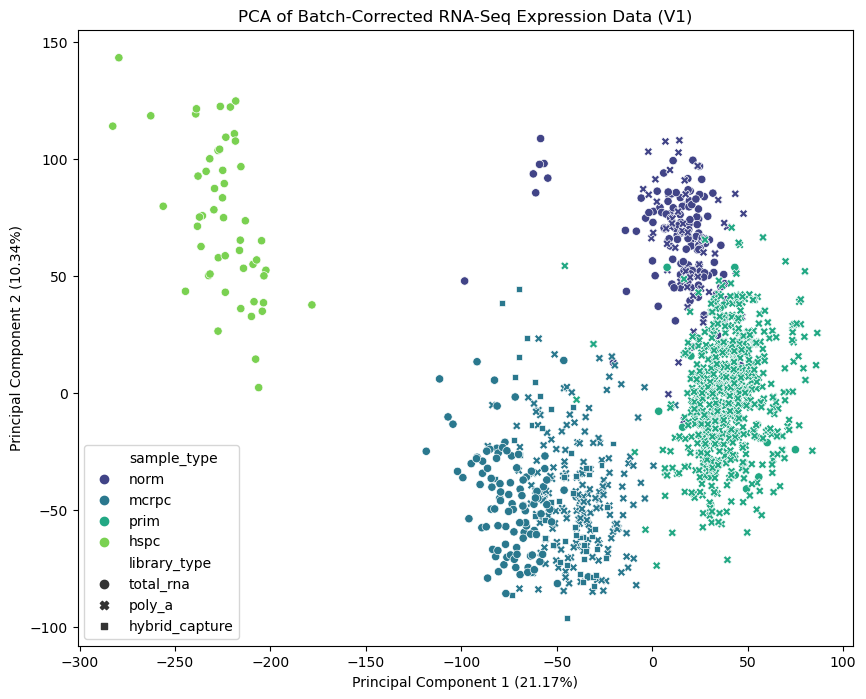

In [32]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="sample_type",
    style="library_type",
    data=pca_df_corrected,
    palette="viridis",
)
plt.title("PCA of Batch-Corrected RNA-Seq Expression Data (V1)")
plt.xlabel(f"Principal Component 1 ({explained_variance[0] * 100:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1] * 100:.2f}%)")
plt.legend(loc="best")
plt.savefig(PCTA_WCDT_GSE221601_ROOT / "data" / "pca_batch_corrected_v1.pdf")
plt.show()

### 3.3. Second batch correction (HSPC samples against all other samples)

In [33]:
batch_clusters = ro.IntVector(
    [
        int(x == "hspc")
        for x in annot_df.loc[counts_df_batch_corrected.columns, "sample_type"]
    ]
)
group = ro.IntVector(
    list(
        LabelEncoder().fit_transform(
            annot_df.loc[counts_df_batch_corrected.columns, "sample_type"]
        )
    )
)

In [34]:
counts_df_batch_corrected_second = combat_seq(
    counts_df=counts_df_batch_corrected.astype(int),
    batch=batch_clusters,
    group=group,
)
counts_df_batch_corrected_second.to_csv(
    PCTA_WCDT_GSE221601_ROOT / "data" / "all_counts_batch_corrected_v2.csv", index=True
)

Found 2 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


#### 3.3.1. PCA Plot

In [35]:
vst_df_batch_corrected_second = rpy2_df_to_pd_df(
    vst_transform(ro.r("as.matrix")(pd_df_to_rpy2_df(counts_df_batch_corrected_second)))
)

In [36]:
pca_corrected_second = PCA(n_components=2)
pca_result_corrected_second = pca_corrected_second.fit_transform(
    vst_df_batch_corrected_second.T
)

pca_result_corrected_second = pd.DataFrame(
    data=pca_result_corrected_second,
    columns=["PC1", "PC2"],
    index=vst_df_batch_corrected_second.columns,
)
pca_result_corrected_second["sample_type"] = annot_df.loc[
    vst_df_batch_corrected_second.columns, "sample_type"
].values
pca_result_corrected_second["dataset"] = annot_df.loc[
    vst_df_batch_corrected_second.columns, "dataset"
].values
pca_result_corrected_second["library_type"] = annot_df.loc[
    vst_df_batch_corrected_second.columns, "library_type"
].values
explained_variance = pca_corrected_second.explained_variance_ratio_

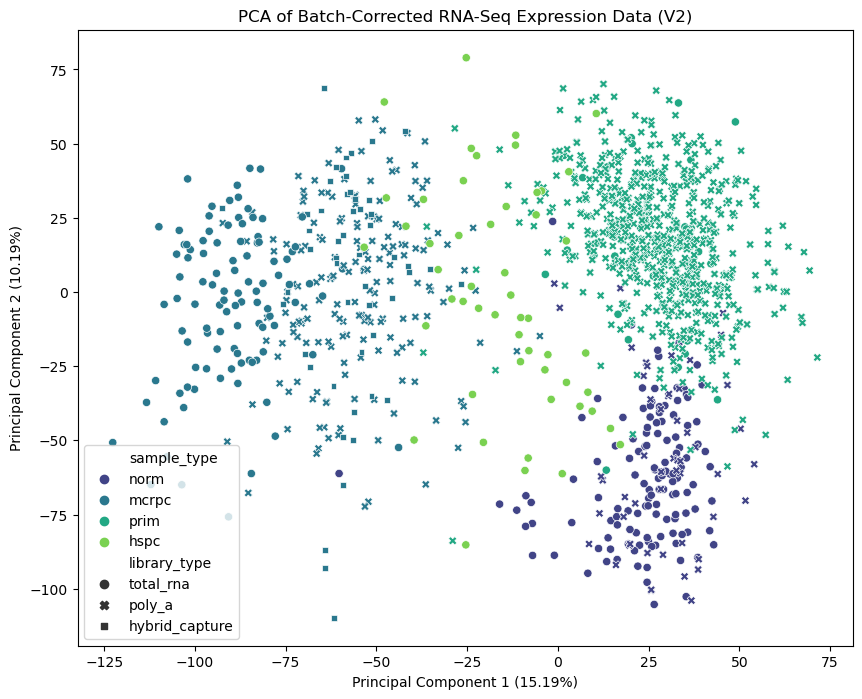

In [37]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="sample_type",
    style="library_type",
    data=pca_result_corrected_second,
    palette="viridis",
)
plt.title("PCA of Batch-Corrected RNA-Seq Expression Data (V2)")
plt.xlabel(f"Principal Component 1 ({explained_variance[0] * 100:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1] * 100:.2f}%)")
plt.legend(loc="best")
plt.savefig(PCTA_WCDT_GSE221601_ROOT / "data" / "pca_batch_corrected_v2.pdf")
plt.show()

### 3.4. Third batch correction (per sample type)

In [38]:
counts_by_type_batch_corrected_third = {}
for sample_type in annot_df["sample_type"].unique():
    df = counts_df_batch_corrected_second[
        annot_df[annot_df["sample_type"] == sample_type].index
    ]
    try:
        counts_by_type_batch_corrected_third[sample_type] = combat_seq(
            df,
            annot_df.loc[df.columns, "dataset_library_type"].tolist(),
        )
    except Exception as e:
        print(f"Failed to batch correct {sample_type}: {e}")
        counts_by_type_batch_corrected_third[sample_type] = df
    counts_by_type_batch_corrected_third[sample_type].to_csv(
        PCTA_WCDT_GSE221601_ROOT
        / "data"
        / f"{sample_type}_batch_corrected_counts_v3.csv"
    )

Found 4 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data
Found 8 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data
Found 4 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data
Found 1 batches


R[write to console]: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels



Failed to batch correct hspc: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels



In [39]:
counts_df_batch_corrected_third = pd.concat(
    counts_by_type_batch_corrected_third.values(), axis=1
).dropna(axis=0)
counts_df_batch_corrected_third.to_csv(
    PCTA_WCDT_GSE221601_ROOT / "data" / "all_counts_batch_corrected_v3.csv", index=True
)

#### 3.4.1. PCA Plot

In [40]:
vst_df_batch_corrected_third = rpy2_df_to_pd_df(
    vst_transform(ro.r("as.matrix")(pd_df_to_rpy2_df(counts_df_batch_corrected_third)))
)

In [41]:
pca_corrected_third = PCA(n_components=2)
pca_result_corrected_third = pca_corrected_third.fit_transform(
    vst_df_batch_corrected_third.T
)

pca_result_corrected_third = pd.DataFrame(
    data=pca_result_corrected_third,
    columns=["PC1", "PC2"],
    index=vst_df_batch_corrected_third.columns,
)
pca_result_corrected_third["sample_type"] = annot_df.loc[
    vst_df_batch_corrected_third.columns, "sample_type"
].values
pca_result_corrected_third["dataset"] = annot_df.loc[
    vst_df_batch_corrected_third.columns, "dataset"
].values
pca_result_corrected_third["library_type"] = annot_df.loc[
    vst_df_batch_corrected_third.columns, "library_type"
].values
explained_variance = pca_corrected_third.explained_variance_ratio_

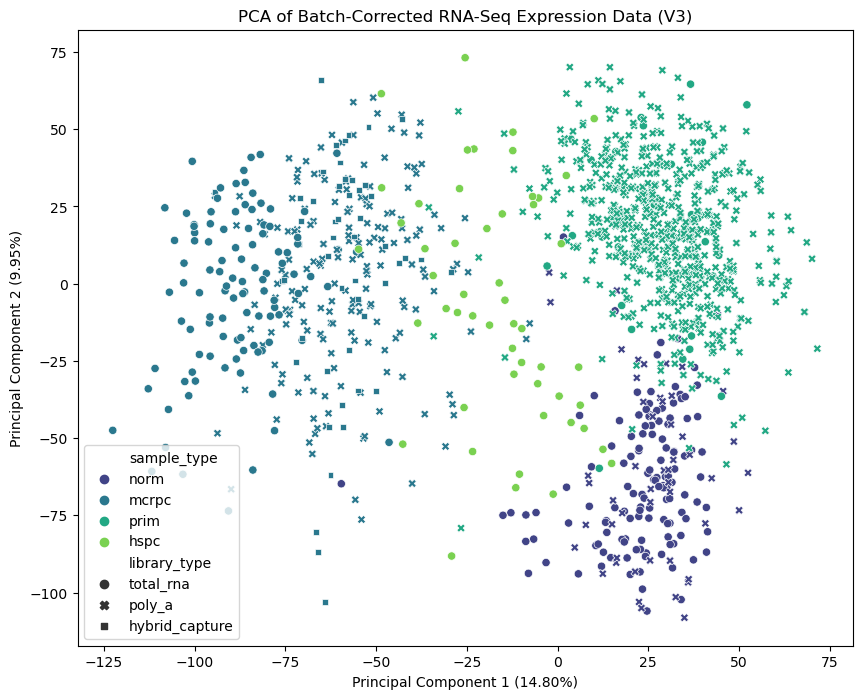

In [42]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="sample_type",
    style="library_type",
    data=pca_result_corrected_third,
    palette="viridis",
)
plt.title("PCA of Batch-Corrected RNA-Seq Expression Data (V3)")
plt.xlabel(f"Principal Component 1 ({explained_variance[0] * 100:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1] * 100:.2f}%)")
plt.legend(loc="best")
plt.savefig(PCTA_WCDT_GSE221601_ROOT / "data" / "pca_batch_corrected_v3.pdf")
plt.show()